In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#import plotly.plotly as py
#py.sign_in('lemoga', 'j891204l')
#import plotly
#import plotly.graph_objs as go
#plotly.offline.init_notebook_mode() # run at the start of every notebook

In [2]:
def getData(npyMatrix, npyLabels):
    matrix = pd.DataFrame(np.load(npyMatrix))#"Order/trainTestMatrixOrderAll.npy"
    matrix.columns = ["CLS"+str(i) for i in range(1,matrix.shape[1]+1)]
    matrix["Labels"] = np.load(npyLabels)#"Order/trainTestLabelsOrderAll.npy"
    return matrix

In [3]:
def attributeEvaluatorFilter(attributeEvaluatorOutput, classificationMatrix):
    attributeEvaluatorOutput.append("Labels")
    return classificationMatrix[attributeEvaluatorOutput]

In [4]:
def getMedian(matrix):
    numLabels = matrix["Labels"].unique()
    if len(numLabels)%2 == 0:
        counts = matrix["Labels"].value_counts().tolist()
        return (count[(len(numLabels)/2)-1]+counts[len(numLabels)/2])/2
    else:
        return matrix["Labels"].value_counts().tolist()[((len(numLabels)+1)/2)-1]

In [5]:
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    return X_resample

In [6]:
def sampler(matrix):
    median = getMedian(matrix)
    #median = matrix["Labels"].value_counts().min()
    lenSample = median/2
    trainIndex = np.array([])
    testIndex = np.array([])
    for label in matrix["Labels"].unique():
        indexLabel = matrix[matrix["Labels"]==label].index.values
        np.random.shuffle(indexLabel)
        if indexLabel.shape[0]>= median:
            trainIndex = np.concatenate((trainIndex,indexLabel[:lenSample]))
            testIndex = np.concatenate((testIndex,indexLabel[lenSample*(-1):]))
        else:
            trainIndex = np.concatenate((trainIndex,bootstrap_resample(indexLabel[:(indexLabel.shape[0]/2)+1],lenSample)))
            testIndex = np.concatenate((testIndex,bootstrap_resample(indexLabel[indexLabel.shape[0]/2:])))
    return trainIndex,testIndex

In [7]:
def classification(matrix, samples, labelsDict):
    allClassiffiers = []
    
    for sample in samples:
        trainIndex = sample[0]
        testIndex = sample[1]
        
        xTrain = matrix.iloc[trainIndex]
        yTrain = xTrain["Labels"]
        xTrain = xTrain.ix[:,xTrain.columns!="Labels"]

        xTest = matrix.iloc[testIndex]
        yTest = xTest["Labels"]
        xTest = xTest.ix[:,xTest.columns!="Labels"]

        clf = RandomForestClassifier(n_estimators=60, max_depth=None, min_samples_split=1, random_state=0)
        clf.fit(xTrain,yTrain)
        yPredict = clf.predict(xTest)
        cm = confusion_matrix(yTest, yPredict, labels=labelsDict.values())
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        allClassiffiers.append([clf, clf.score(xTest, yTest),cm_normalized])
        
    return allClassiffiers

In [8]:
def getMeanImportance(allClassiffiers):
    importance = pd.DataFrame()

    for i in range(len(allClassiffiers)):
        clf = allClassiffiers[i][0]
        varImportance = clf.feature_importances_
        importance[i] = varImportance
        #std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
        #indices = np.argsort(varImportance)[::-1][0:830] #num viphogs importantes orden

    mean = importance.mean(axis=1)
    std = importance.std(axis=1)
    order = list(np.argsort(mean)[::-1])

    meanSorted = []
    stdSorted = []
    for viphog in order:
        meanSorted.append(mean[viphog])
        stdSorted.append(std[viphog])
    
    return order, meanSorted, stdSorted

In [9]:
def is_outlier(points, thresh=3.5):
    """
    Taken from
    http://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data#22357811
    26/03/2017
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [10]:
#matrix = getData("Order/trainTestMatrixOrderAll.npy","Order/trainTestLabelsOrderAll.npy")
matrix = getData("Genus/trainTestMatrixGenusAll.npy","Genus/trainTestLabelsGenusAll.npy")

In [11]:
#spOutput = list(pd.read_csv("../2_SP/Order/specificityPrecissionOrder.txt", sep="\t",header=0, index_col=0).index.values)
spOutput = list(pd.read_csv("../2_SP/Genus/specificityPrecissionGenera.txt", sep="\t",header=0, index_col=0).index.values)
with open("../../12_MutualInformation/4_ViPhOGselection/importantViphogsMIGenus.csv") as miFile:
    miOutput = ["CLS"+line.strip('\n') for line in miFile]

spmi = list(set(spOutput + miOutput))
reducedMatrix = attributeEvaluatorFilter(spmi, matrix)
pd.DataFrame.head(reducedMatrix)
reducedMatrix.to_csv("Genus300320/reducedViphogsMatrix.csv",header=True,index=False,sep='\t')

In [10]:
reducedMatrix = pd.read_csv("Genus300320/reducedViphogsMatrix.csv",header=0,sep='\t')

In [11]:
samples = []
for i in range(100):
    trainIndex, testIndex = sampler(reducedMatrix)
    samples.append((trainIndex,testIndex))

In [12]:
labelsDict = np.load("Genus/trainTestLabelsDictGenusAll.npy").item()

In [13]:
%time allClassiffiers = classification(reducedMatrix, samples[:100], labelsDict)

CPU times: user 9min 48s, sys: 12.8 s, total: 10min 1s
Wall time: 11min 11s


In [14]:
importanceOrder, meanImportance, stdImportance = getMeanImportance(allClassiffiers)
order = []
for i in importanceOrder:
    order.append(reducedMatrix.columns.values[i])

In [15]:
fw = open("Genus300320/viphogs.sortedByImportance.csv","w")
for viphog in order:
    fw.write(viphog+'\n')

In [16]:
i=0
for x in is_outlier(np.array(meanImportance)):
    if x:
        i+=1
    else:
        break
        
#fw = open("importantViphogs.Order.csv")
fw = open("Genus300320/importantViphogs.outliersImportance.csv","w")
for viphog in order[:i]:
    fw.write(viphog+'\n')

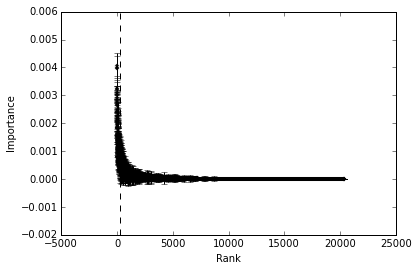

In [17]:
#plt.figure(figsize=(20,10))
ax = sns.scatterplot(y=meanImportance,x=range(len(meanImportance)),color="black",markers='o')
plt.errorbar(y=meanImportance,x=range(len(meanImportance)),fmt='o',ms=2,
             xerr=None,yerr=stdImportance,color="black")
plt.axvline(x=284,color="Black",linestyle='--')
ax.set(xlabel="Rank",ylabel="Importance")
ax.figure.savefig("Genus300320/viphogsImportance.pdf")

In [22]:
trace1 = go.Scattergl(y=meanImportance, x=[i for i in range(len(importanceOrder))],
                      error_y=dict(type='data', array=stdImportance),mode="markers")

#trace1 = go.Scattergl(y=[c[1]for c in allClassiffiers], x=[i for i in range(len(allClassiffiers))],
#                      mode="markers")
layout = go.Layout(title="ViPhogs Importance")#width=1400,#autozise=False)
fig = go.Figure(data=[trace1], layout=layout)
plotly.offline.iplot(fig)

In [18]:
subColumns = order
numViPhogs = []
meanScore = []
stdScore = []
while len(subColumns) > 2:
    decreasingMatrix = reducedMatrix[subColumns+["Labels"]]
    allSelectionClassifiers = classification(decreasingMatrix, samples[:3], labelsDict)
    numViPhogs.append(len(subColumns))
    scores = [c[1] for c in allSelectionClassifiers]
    meanScore.append(np.mean(np.array(scores)))
    stdScore.append(np.std(np.array(scores)))
    subColumns = subColumns[:(len(subColumns)/5)*4]

In [19]:
i=0
for x in is_outlier(np.array(meanScore[::-1])):
    if x:
        i+=1
    else:
        break
i

0

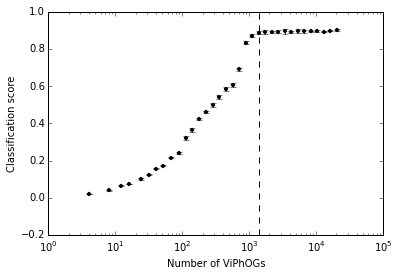

In [22]:
ax = sns.scatterplot(y=meanScore[::-1], x=numViPhogs[::-1],color="Black")
plt.errorbar(y=meanScore[::-1], x=numViPhogs[::-1],yerr=stdScore[::-1],color="Black",fmt='o',ms=3)
ax.axvline(numViPhogs[12],color="Black",linestyle="--")
ax.set(xscale='log',xlabel="Number of ViPhOGs",ylabel="Classification score")
ax.figure.savefig("Genus300320/classificationScore.pdf")

In [23]:
fw = open("Genus300320/importantViphogs.minNumberBestScore.csv","w")
for viphog in order[:numViPhogs[-17]]:
    fw.write(viphog+'\n')
fw.close()

In [20]:
trace1 = go.Scattergl(y=meanScore[::-1], x=numViPhogs[::-1],#x=[i for i in range(len(meanScore))], 
                      error_y=dict(type='data', array=stdScore[::-1], visible=True, color='black', thickness=0.5),
                      name="100", mode="markers", marker = dict(size = 5))

layout = go.Layout(title="Classification Score Vs Num. of ViPhOGs", xaxis=dict(type='log'))#width=1400,#autozise=False)
fig = go.Figure(data=[trace1], layout=layout)
plotly.offline.iplot(fig)

In [24]:
cm_normalized = sum([c[2] for c in allClassiffiers])/len(allClassiffiers)
#Save it as a pandas dataframe
cm_normalized_df = pd.DataFrame(cm_normalized)
#Add labels
labelsDict_inv = {v:k for k,v in labelsDict.iteritems()}
cm_normalized_df.rename(index=labelsDict_inv,columns=labelsDict_inv,inplace=True)
cm_normalized_df.to_csv("Genus300320/confussionMatrix.csv",header=True,index=True,sep='\t')

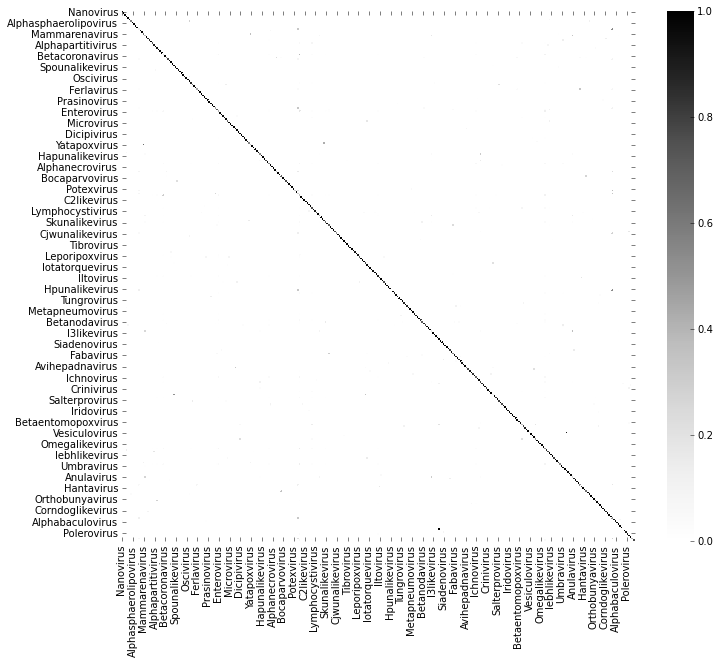

In [25]:
plt.figure(figsize=(11.5,9.5))
ax = sns.heatmap(cm_normalized_df,cmap="Greys")
#ax.set(xticklabels=cm_normalized_df.index.values,xticks=np.arange(cm_normalized_df.shape[0]),
#       yticklabels=cm_normalized_df.index.values,yticks=np.arange(cm_normalized_df.shape[0]))
ax.figure.savefig("Genus300320/confussionMatrix.pdf")

In [2]:
cm_normalized_df = pd.read_csv("Genus300320/confussionMatrix.csv",header=0,index_col=0,sep='\t')
np.diag(np.matrix(cm_normalized_df.as_matrix())).mean()

0.89578606965174346

In [12]:
#load taxonomy annotation of all genomes
taxonomy = pd.read_csv("../../7_DBtests/iv_queries/taxonomyAnotation.csv",header=0,sep=',')
#keep only order an family annotation
taxonomy = taxonomy[["Order","Family","Genus"]]
taxonomy = taxonomy.drop_duplicates()

In [10]:
#As some families were not included in the classification process (because of the low number of representatives) ->
# -> keep only families in the cm_matrix
cm_labels = pd.DataFrame(cm_normalized_df.index)
cm_labels.columns = ["Genus"]
taxonomy = taxonomy.merge(right=cm_labels,left_on="Genus",right_on="Genus",how="inner")
#Sort taxonomy
taxonomy.sort_values(by=["Order","Family","Genus"],inplace=True)
#Sort the cm_matrix by taxonomy
cm_normalized_df = cm_normalized_df.loc[taxonomy["Genus"]][taxonomy["Genus"]].copy()

In [9]:
print taxonomy.shape
print cm_normalized_df.shape

(335, 3)
(335, 335)


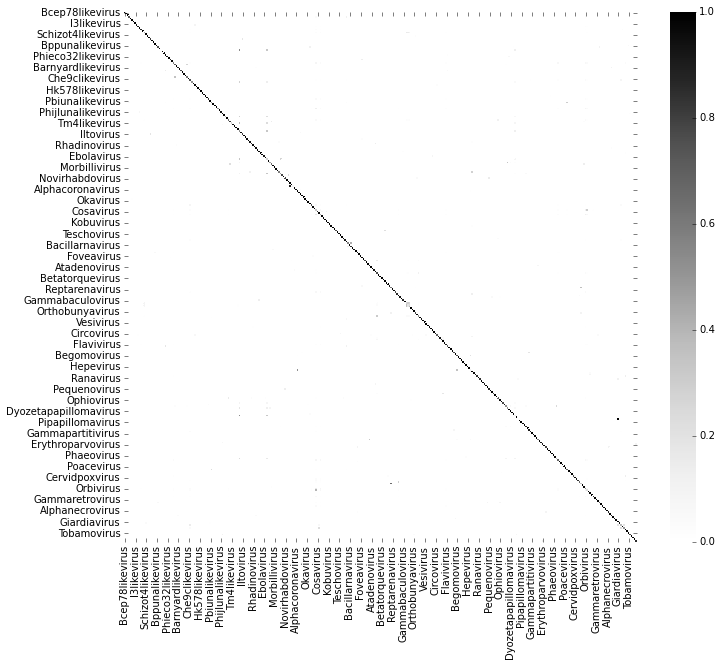

In [11]:
plt.figure(figsize=(11.5,9.5))
ax = sns.heatmap(cm_normalized_df,cmap="Greys")
#ax.set(xticklabels=cm_normalized_df.index.values,xticks=np.arange(cm_normalized_df.shape[0]),
#       yticklabels=cm_normalized_df.index.values,yticks=np.arange(cm_normalized_df.shape[0]))
ax.figure.savefig("Genus300320/confussionMatrix.sorted.pdf")

In [10]:
#Plot presence/absence matrix of the signature viphogs

In [17]:
#Load data
reducedMatrix = pd.read_csv("Genus300320/reducedViphogsMatrix.csv",header=0,sep='\t')
labelsDict = np.load("Genus/trainTestLabelsDictGenusAll.npy").item()
sigViphogs = pd.read_csv("Genus300320/importantViphogs.minNumberBestScore.csv",header=None)
sigViphogs = sigViphogs[0].values
sigViphogs = np.append(sigViphogs,"Labels")
#Reduce the matrix to the signature viphogs
reducedMatrix = reducedMatrix[sigViphogs].copy()

In [18]:
#dict is taxName : value and is changed for value:taxname
labelsDict = dict(zip(labelsDict.values(),labelsDict.keys()))
#Append taxonomy information to the viphogs matrix
getGenus = lambda x : labelsDict[x]
    #Add Family names
reducedMatrix["Genus"] = reducedMatrix["Labels"].apply(getGenus)
    #Add higher tax names
reducedMatrix = reducedMatrix.merge(right=taxonomy,left_on="Genus",right_on="Genus",how="inner").copy()
#Sort matrix by taxonomy
reducedMatrix = reducedMatrix.sort_values(by=["Order","Family","Genus"],ascending=True).copy()

In [21]:
train,test = sampler(reducedMatrix)
train = reducedMatrix.iloc[train].copy()
test = reducedMatrix.iloc[test].copy()
#Sort sample by taxonomy
train = train.sort_values(by=["Order","Family","Genus"],ascending=True).copy()
test = test.sort_values(by=["Order","Family","Genus"],ascending=True).copy()

In [30]:
trainToPlot = train[sigViphogs].copy()
sigViphogsOrder = []
for i in trainToPlot["Labels"].unique():
    cases = trainToPlot[trainToPlot["Labels"]==i].sum(axis=0)
    for viphog in trainToPlot.columns[cases>0]:
        if viphog == "Labels":
            continue
        else:
            sigViphogsOrder.append((i,viphog,cases[viphog]))

In [31]:
def appendViphog(viphog):
    tax.append(viphog[0])
    cluster.append(viphog[1])
    count.append(viphog[2])
def removeViphog(i):
    tax.pop(i)
    cluster.pop(i)
    count.pop(i)
    
tax,cluster,count = [],[],[]
for viphog in sigViphogsOrder:
    if viphog[1] in cluster:
        i = cluster.index(viphog[1])
        if viphog[2] > count[i]:
            removeViphog(i)
            appendViphog(viphog)
    else:
        appendViphog(viphog)

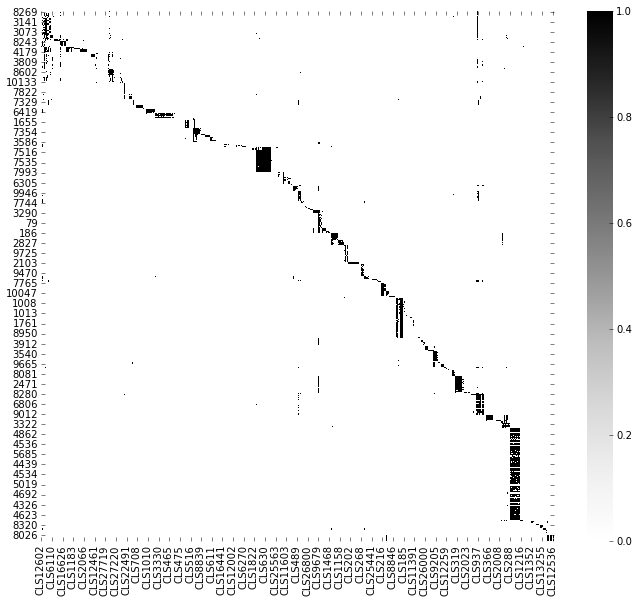

In [25]:
plt.figure(figsize=(11.5,9.5))
testToPlot = test[cluster].copy()
testToPlot[testToPlot!=0]=1
ax = sns.heatmap(testToPlot[cluster],cmap="Greys")
ax.figure.savefig("Genus300320/importantViPhOGs.presenceAbsenceMatrix.pdf")

In [39]:
aux = train[["Labels","Genus","Family","Order"]].drop_duplicates()
tax = [aux[aux["Labels"]==x][["Genus","Family","Order"]] for x in tax]
fw = open("Genus300320/importantViPhOGs.taxAnnotation.csv","w")
fw.write("ViPhOG\tGenus\tFamily\tOrder\n")
for i in range(len(cluster)):
    #print i
    fw.write(cluster[i]+'\t'+str(tax[i]["Genus"].values[0])+'\t'+str(tax[i]["Family"].values[0])+'\t'+str(tax[i]["Order"].values[0])+'\n')
fw.close()

In [3]:
missclassification = []
for index,row in cm_normalized_df.iterrows():
    row = row[row>0]
    for i,x in row.iteritems():
        if i != index:
            missclassification.append((index,i,x))

In [12]:
missDF = pd.DataFrame(missclassification,columns=["Label","Prediction","MissRate"])
missDF["Level"] = ["Genus"]*len(missclassification)

In [13]:
missDF

,Label,Prediction,MissRate,Level
0,Tepovirus,Sp6likevirus,0.010000,Genus
1,Norovirus,Chilikevirus,0.003333,Genus
2,Norovirus,Totivirus,0.003333,Genus
3,Norovirus,Sequivirus,0.063333,Genus
4,Rubulavirus,Plectrovirus,0.286667,Genus
5,Rubulavirus,Percavirus,0.120000,Genus
6,Copiparvovirus,Carmovirus,0.003333,Genus
7,Kappapapillomavirus,Nyavirus,0.330000,Genus
8,Kappapapillomavirus,Cyprinivirus,0.540000,Genus
9,Dependoparvovirus,Reylikevirus,0.073333,Genus


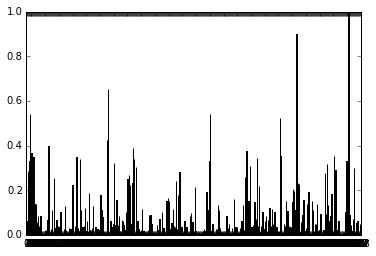

In [4]:
ax = sns.barplot(y=[x[2] for x in missclassification],x=range(len(missclassification)))

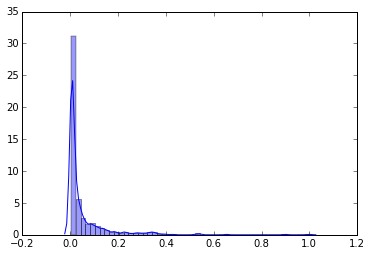

In [5]:
ax = sns.distplot([x[2] for x in missclassification])